<a href="https://colab.research.google.com/github/MastellaM/tactile_braille_reading_encoding/blob/main/notebooks/NM_neuron_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=d49900b73af1a29116fd20545094086b6187d9b254d62e3c176ca980102a936c
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
import torch
from torch import nn
from math import sqrt
import numpy as np
from torchviz import make_dot
import matplotlib.pyplot as plt
from collections import namedtuple

In [ ]:
class MN_neuron(nn.Module):
    # we save the state of the neuron in a namedtuple (Similar to a dictionary)
    NeuronState = namedtuple('NeuronState', ['V', 'i1', 'i2', 'Thr'])

    def __init__(self, n_in, n_out, a, A1, A2):
        super(MN_neuron, self).__init__()
        
        self.linear = nn.Linear(n_in, n_out, bias=False)
        #torch.nn.init.eye_(self.linear.weight)
        torch.nn.init.constant_(self.linear.weight, 2.0)
        self.C = 1
        
        self.EL = -0.07
        self.Vr = -0.07
        self.R1 = 0
        self.R2 =  1
        self.Tr = -0.06
        self.Tinf = -0.05

        self.b = 10 # units of 1/s
        self.G = 50 * self.C  # units of 1/s
        self.k1 = 200 # units of 1/s
        self.k2 = 20 # units of 1/s

        self.dt = 1/1000

        #self.a = nn.Parameter(torch.tensor(a), requires_grad=True)
        self.a = nn.Parameter(torch.ones(1,n_out)*a, requires_grad=True)
        #torch.nn.init.constant_(self.a, a)
        self.A1 = A1 * self.C 
        self.A2 = A2 * self.C
        
        self.state = None

    def forward(self, x):
        if self.state is None:
            self.state = self.NeuronState(V = torch.ones(x.shape[0], n_out, device=x.device) * self.EL,
                                          i1 = torch.zeros(x.shape[0], n_out, device=x.device),
                                          i2 = torch.zeros(x.shape[0], n_out, device=x.device),
                                          Thr = torch.ones(x.shape[0], n_out, device=x.device) * self.Tr)

        V = self.state.V
        i1 = self.state.i1
        i2 = self.state.i2
        Thr = self.state.Thr

        i1 += -self.k1*i1 *self.dt
        i2 += -self.k2*i2 *self.dt
        V += self.dt*(self.linear(x) + i1 + i2 - self.G*(V-self.EL)) / self.C
        Thr += self.dt*(self.a*(V - self.EL) - self.b*(Thr - self.Tinf))

        spk = activation(V - Thr)

        i1   = (1-spk)*i1 + (spk)*(self.R1*i1 +self.A1)
        i2   = (1-spk)*i2 + (spk)*(self.R2*i2 +self.A2)
        Thr  = (1-spk)*Thr + (spk)*torch.max(Thr, torch.tensor(self.Tr))
        V    = (1-spk)*V + (spk)*self.Vr

        self.state = self.NeuronState(V = V, i1 = i1, i2 = i2, Thr = Thr)

        return spk

class SurrGradSpike(torch.autograd.Function):
    scale = 20.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return (input > 0.).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad = grad_output/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad

activation = SurrGradSpike.apply
    

# Training
We are gonna train the network to emit 4 and 8 spikes. For that, the loss function is defined as the MSE of the sum of spikes and the objective number of spikes (8 and 4)

In [ ]:
from torch.nn import parameter
DEVICE = "cpu"
n_in = 1
n_out =2
BATCH_SIZE = 1
TOTTIME = 1000
Ie = torch.tensor(1.5).view(1,1)

Net = MN_neuron(n_in, n_out, 5., 0., 0.)


optimizer = torch.optim.SGD(params=Net.parameters(), lr=1e-2)
for epoch in range(200):
    spikes = 0
    voltages = []
    for t in range(100):
        spikes += Net(Ie)
        voltages.append(Net.state.V.clone().detach().cpu().numpy())

    voltages = np.stack(voltages)
    mse = torch.sum((spikes - torch.tensor([8,4]))**2)

    optimizer.zero_grad()
    #Loss = torch.nn.MSELoss()
    #mse = Loss(spikes[t], torch.ones_like(spikes[t]))
    mse.backward()
    optimizer.step()

    for state in Net.state:
        state.detach_()

    #make_dot(mse, params=dict(Net.named_parameters()))


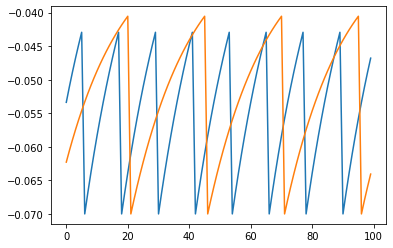

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(voltages[:,0,:])

In [ ]:
Net.a

Parameter containing:
tensor([[4.9925, 5.0428]], requires_grad=True)